<h3>Statistical analisys of Gesture Recognizer App</h3>
<p> 
    This application binds a predefined gesture set to a predefined command set, 
</p>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json

# This script reads JSON files from a specified directory, converts them into pandas DataFrames,
# and concatenates them into a single DataFrame. It then prints the first 5 rows of the resulting DataFrame.
file_list = glob.glob('../client/static/configs/*.json')

df_list = []
for file in file_list:
    with open(file, 'r') as f:
        data = json.load(f)
        df_list.append(pd.DataFrame([data]))
# ignore_index=True to reset the index in the concatenated DataFrame.
# pandas creates a new increasing index (0, 1 , 2, ...) for the resulting DataFrame. 
full_df = pd.concat(df_list, ignore_index=True)
print(full_df.head())

       Thumb_Up   Thumb_Down    Open_Palm   Closed_Fist          Victory  \
0     Volume Up  Volume Down    Scroll Up   Scroll Down           AltTab   
1        AltTab  Scroll Down   Screenshot  Task Manager        Scroll Up   
2  Task Manager    Volume Up  Scroll Down     PlayPause  Open Calculator   
3    Screenshot  Volume Down    PlayPause        AltTab  Open Calculator   
4     Scroll Up  Scroll Down    PlayPause        AltTab        Volume Up   

          ILoveYou      Pointing_Up  
0        PlayPause           AltTab  
1        Volume Up  Open Calculator  
2           AltTab      Volume Down  
3        Scroll Up     Task Manager  
4  Open Calculator      Volume Down  


       Gesture           Command  Count
0  Closed_Fist  -- No Command --      7
1  Closed_Fist            AltTab      6
2  Closed_Fist   Open Calculator      6
3  Closed_Fist         PlayPause      9
4  Closed_Fist        Screenshot      8


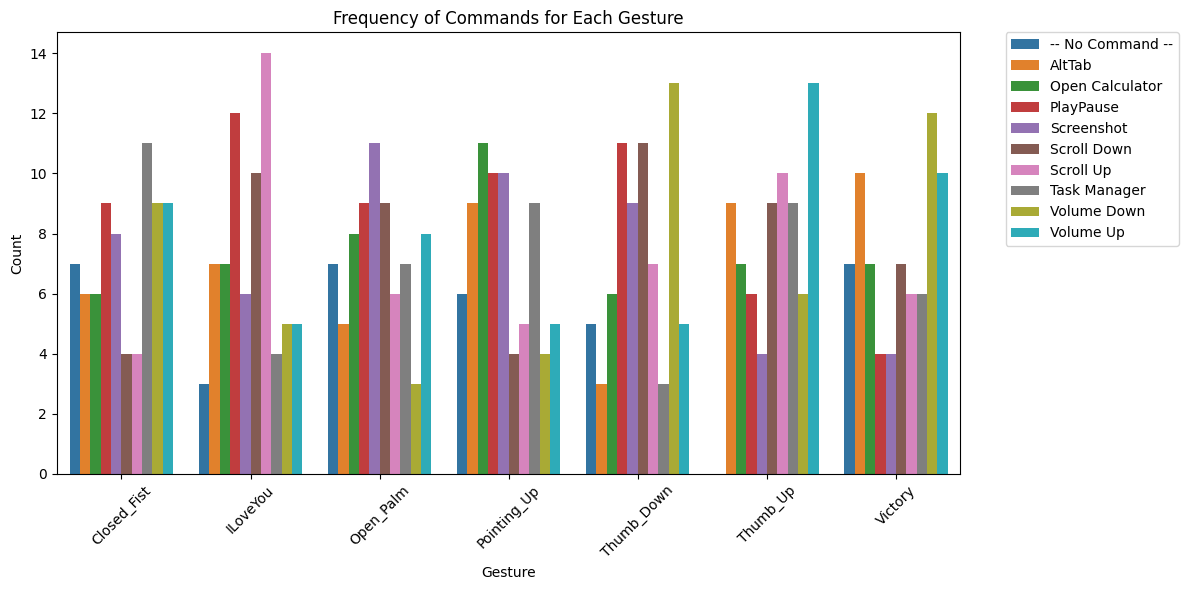

In [24]:
# Convert the DataFrame to a long format for easier plotting
# We use this to use a single column for gestures and another for commands.
# This allows us to easily count the occurrences of each command for each gesture.
long_df = full_df.melt(var_name='Gesture', value_name='Command')

# reset_index to ensure that the index is reset after melting
# after group by, the new indexes will be 0, 1, 2, ... for each unique combination of Gesture and Command. 
counts_df = long_df.groupby(['Gesture', 'Command']).size().reset_index(name='Count')

print(counts_df.head())


import seaborn as sns

# Set the style of seaborn
plt.figure(figsize=(12, 6))
# Hue is used to differentiate between commands
sns.barplot(data=counts_df, x='Gesture', y='Count', hue='Command')
plt.title("Frequency of Commands for Each Gesture")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# tight_layout to ensure that the plot fits well within the figure area
plt.tight_layout()
plt.show()

            Command  Count
0         PlayPause     61
1         Volume Up     55
2       Scroll Down     54
3        Screenshot     52
4         Scroll Up     52
5   Open Calculator     52
6       Volume Down     52
7            AltTab     49
8      Task Manager     49
9  -- No Command --     35


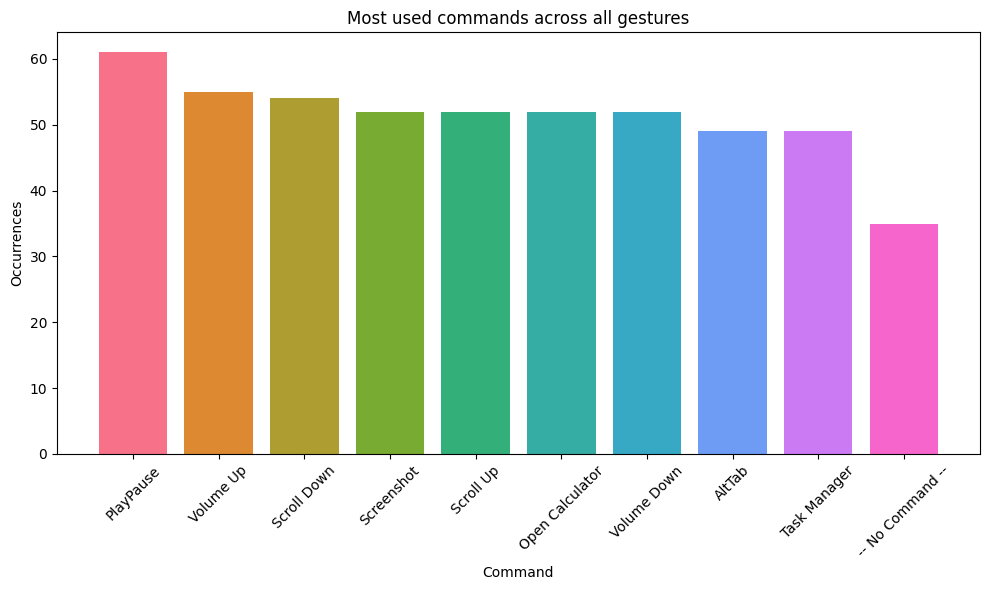

In [25]:
# Count the occurrences of each command across all gestures
# This will give us a summary of how many times each command is used.
# We can use this to create a bar chart of the most used commands.
command_counts = long_df['Command'].value_counts().reset_index()
command_counts.columns = ['Command', 'Count']
print(command_counts)

# Generate a different color for each command
# You can use seaborn or matplotlib colormaps
import seaborn as sns
palette = sns.color_palette("husl", len(command_counts))  # distinct colors

# Bar chart of the most used commands
plt.figure(figsize=(10, 6))
plt.bar(command_counts['Command'], command_counts['Count'], color=palette)
plt.title('Most used commands across all gestures')
plt.xlabel('Command')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


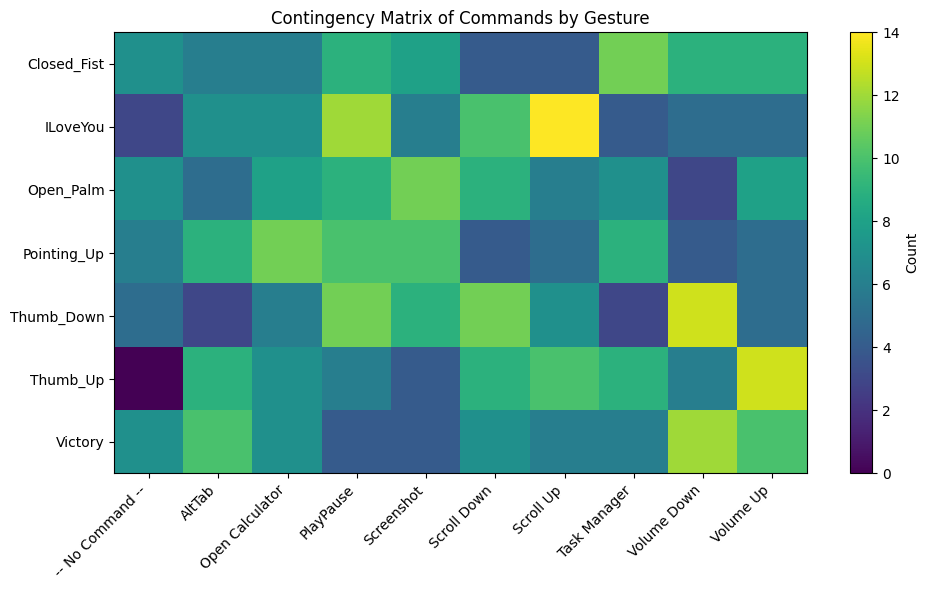

In [26]:
# matrix of contingency counts
# This will create a matrix where rows are gestures and columns are commands,
# and the values are the counts of each command for each gesture.
# We use pivot to reshape the DataFrame into a matrix format.
# The index will be the 'Gesture', the columns will be the 'Command', and the values will be the 'Count'.
# fillna(0) is used to replace NaN values
cont_matrix = counts_df.pivot(index='Gesture',
                              columns='Command',
                              values='Count') \
                       .fillna(0)

# Plot the contingency matrix
plt.figure(figsize=(10, 6))

# aspect='auto' allows the matrix to be displayed with equal aspect ratio
# This means that the cells will be square, making it easier to visualize the counts.
plt.imshow(cont_matrix, aspect='auto')
plt.colorbar(label='Count')

# Set the ticks and labels for the x and y axes
# We use range(len(...)) to get the positions for the ticks,
# and we use the index and columns of the DataFrame for the labels.
# rotation=45 and ha='right' to make the labels more readable.
plt.xticks(range(len(cont_matrix.columns)),
           cont_matrix.columns,
           rotation=45, ha='right')
plt.yticks(range(len(cont_matrix.index)),
           cont_matrix.index)
plt.title("Contingency Matrix of Commands by Gesture")
plt.tight_layout()
plt.show()


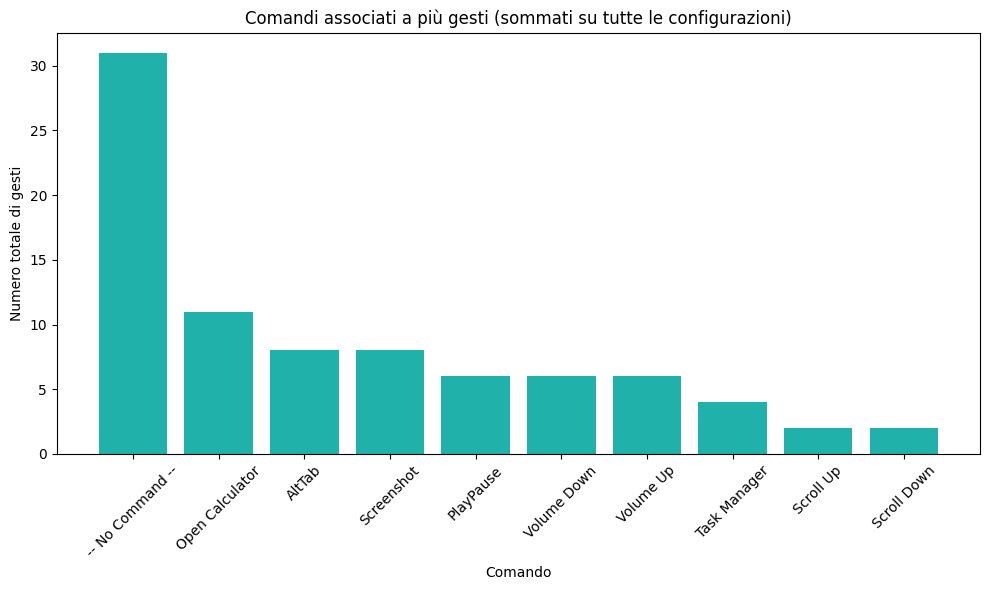

In [ ]:
from collections import Counter, defaultdict

# Dizionario: comando → numero totale di gesti a cui è stato associato (in singole config)
command_to_multi_gestures = defaultdict(int)
fix_df = long_df[long_df['Command'] != '-- no command --']
# Cicla ogni configurazione separatamente
for row in full_df.itertuples(index=False):
    row_dict = row._asdict()
    gesture_to_command = row_dict

    # Conta quanti gesti sono associati a ciascun comando (in quella config)
    count = Counter(gesture_to_command.values())

    # Per ogni comando con ≥2 gesti, accumula il numero di gesti
    for cmd, n in count.items():
        if n > 1:
            command_to_multi_gestures[cmd] += n

# Trasforma in DataFrame per il grafico
plot_df = pd.DataFrame(command_to_multi_gestures.items(), columns=['Command', 'Total_Gestures'])

# Ordina per numero di gesti decrescente
plot_df = plot_df.sort_values(by='Total_Gestures', ascending=False)

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(plot_df['Command'], plot_df['Total_Gestures'], color='lightseagreen')
plt.title('Comandi associati a più gesti (sommati su tutte le configurazioni)')
plt.xlabel('Comando')
plt.ylabel('Numero totale di gesti')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
